In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import cross_validation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle
from scipy.sparse import csr_matrix
from sklearn.pipeline import make_union
from sklearn.decomposition import TruncatedSVD

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Problem Description
======================

1. This challenge is taken from kaggle https://www.kaggle.com/c/mercari-price-suggestion-challenge 
1. MerCari is an online platform where sellers put up items with descriptions and buyers buy the items for a price
1. The task is to predict the price of the item put up by the seller based on the Item title, description, brand, Category,
condition and shipping charges.
1. This will help the seller validate where the price for the item is rigth or not

## Data is downloaded from the kaggle website

In [2]:
all_df = pd.read_csv('train.csv',sep='\t')
all_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [15]:
all_df.shape

(1482535, 8)

## Duplicate entries check

In [18]:
all_df[all_df.duplicated(['name'])].sort_values(['name']).shape

(257262, 8)

In [19]:
257262/1482535

0.17352844958129152

> There are duplicated names, ~17% of the names are duplicated. But it possible that different sellers and brands provide the same name, so checking the duplication of name, brand_name, price, item_description

In [25]:
# These duplicated values can be removed. i.e only keep one entry and remove duplicated entries
all_df[all_df.duplicated(['name','brand_name','price','item_description'], keep=False)].sort_values(['name'])

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1341041,1341041,!1 Hour Sale! Powerbeats2 Wireless [rm]!,1,Electronics/Cell Phones & Accessories/Headsets,Beats,60.0,1,Brand new 5 colors: GRAY WITH BLUE GRAY WITH R...
810104,810104,!1 Hour Sale! Powerbeats2 Wireless [rm]!,1,"Electronics/TV, Audio & Surveillance/Headphones",Beats,60.0,1,Brand new 5 colors: GRAY WITH BLUE GRAY WITH R...
1437174,1437174,#12 anastasia eyebrow brush,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,Anastasia Beverly Hills,10.0,1,"Smooth bristles, but sharp enough to get that ..."
411084,411084,#12 anastasia eyebrow brush,1,Beauty/Makeup/Eyes,Anastasia Beverly Hills,10.0,1,"Smooth bristles, but sharp enough to get that ..."
1318927,1318927,#PINK YETI TUMBLER,1,Vintage & Collectibles/Serving/Tumbler,NaN,25.0,1,(PINK) YETI Powder Coated Tumbler 30 oz We als...
312615,312615,#PINK YETI TUMBLER,1,Vintage & Collectibles/Housewares/Cup,NaN,25.0,1,(PINK) YETI Powder Coated Tumbler 30 oz We als...
1321326,1321326,'4 iPhone Cables,1,Electronics/Cell Phones & Accessories/Cables &...,NaN,6.0,1,Iphone 5/6/7 certified chargers 4* [rm] 5* [rm...
874114,874114,'4 iPhone Cables,1,Electronics/Cell Phones & Accessories/Chargers...,NaN,6.0,1,Iphone 5/6/7 certified chargers 4* [rm] 5* [rm...
720432,720432,'[rm] iPhone Cable Bundle,1,Electronics/Cell Phones & Accessories/Cables &...,NaN,7.0,1,5x[rm] HUGE SALE FREE SHIPPING GREAT QUALITY I...
1045721,1045721,'[rm] iPhone Cable Bundle,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,7.0,1,5x[rm] HUGE SALE FREE SHIPPING GREAT QUALITY I...


In [26]:
all_df[all_df.duplicated(['name','brand_name','price','item_description'], keep=False)].shape

(3237, 8)

In [3]:
all_df.drop_duplicates(subset=['name','brand_name','price','item_description'], inplace=True)
all_df.shape

(1480845, 8)

## Exploratory Data Analysis

In [28]:
all_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

### Price

In [31]:
all_df.price.describe()

count    1.480845e+06
mean     2.675258e+01
std      3.860418e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

__*The minimum price is zero*__

<IPython.core.display.Javascript object>


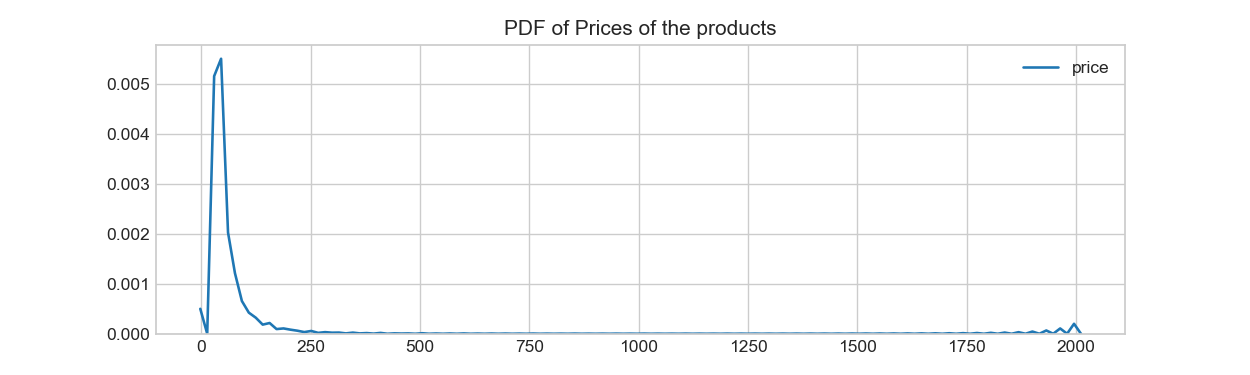

In [65]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("PDF of Prices of the products")
sns.kdeplot(all_df['price'], ax = ax)
plt.show()

__Prices following pareto distribution__ <br> $\therefore$ __applying__ $\log(1 + price) \rightarrow$ __"1 +" to cater for the zeros__

<IPython.core.display.Javascript object>


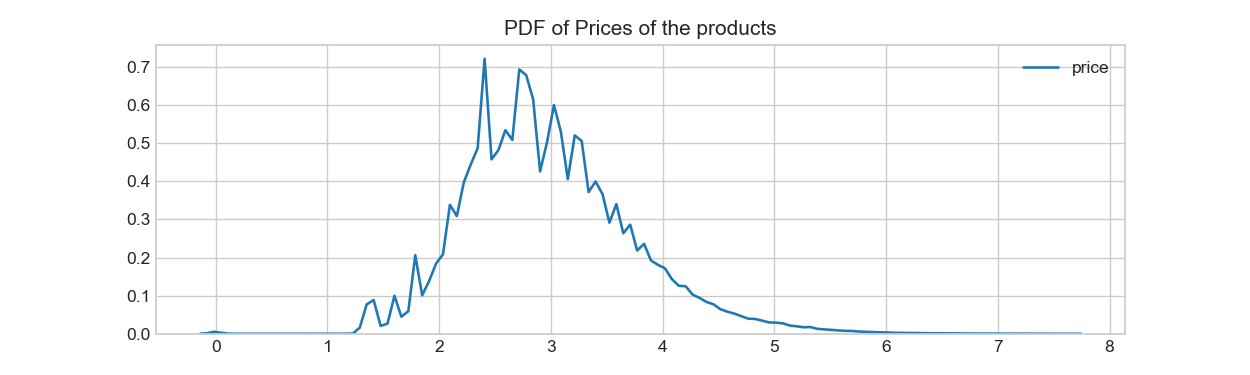

In [68]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("PDF of Prices of the products")
sns.kdeplot(np.log(1+all_df['price']), ax = ax)
plt.show()

### Item Condition

In [70]:
all_df.item_condition_id.unique()

array([3, 1, 2, 4, 5], dtype=int64)

In [105]:
all_df.item_condition_id.value_counts()

1    639181
3    432026
2    375310
4     31944
5      2384
Name: item_condition_id, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


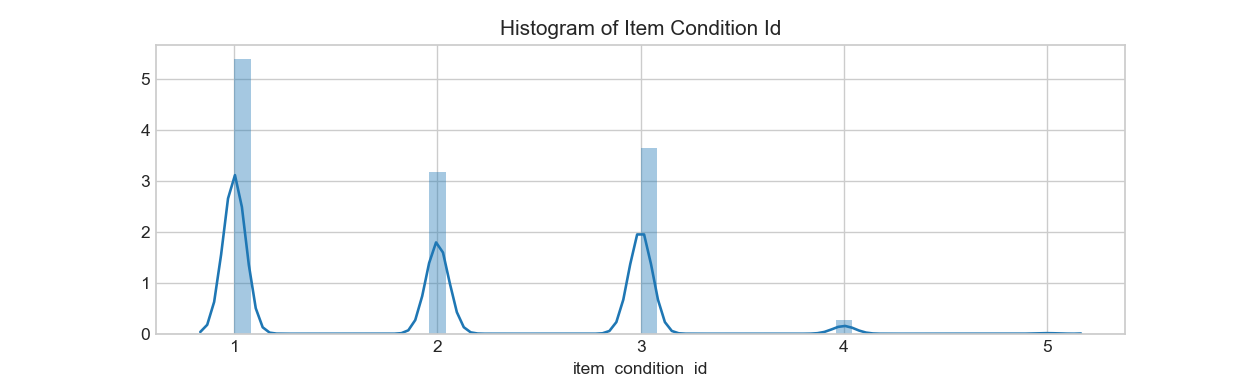

In [76]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Histogram of Item Condition Id")
sns.distplot(all_df.item_condition_id, hist=True)
plt.show()

<IPython.core.display.Javascript object>


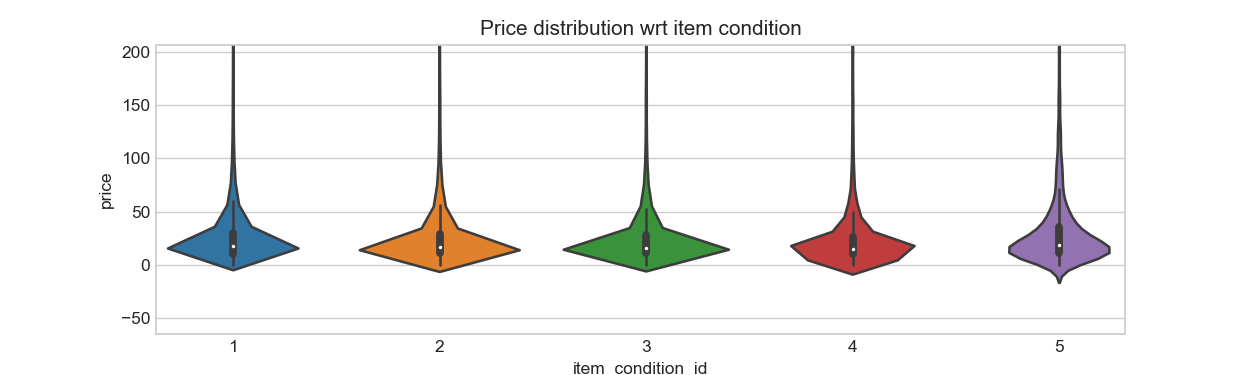

In [84]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Price distribution wrt item condition")
sns.violinplot(x = 'item_condition_id', y = 'price',\
           data = all_df)
plt.show()

In [87]:
item_conditions = all_df.item_condition_id.unique()
# x -> list of lists. Each item condition has a list of prices
x = [all_df.loc[all_df['item_condition_id']==ic, 'price'] for ic in item_conditions]

<IPython.core.display.Javascript object>


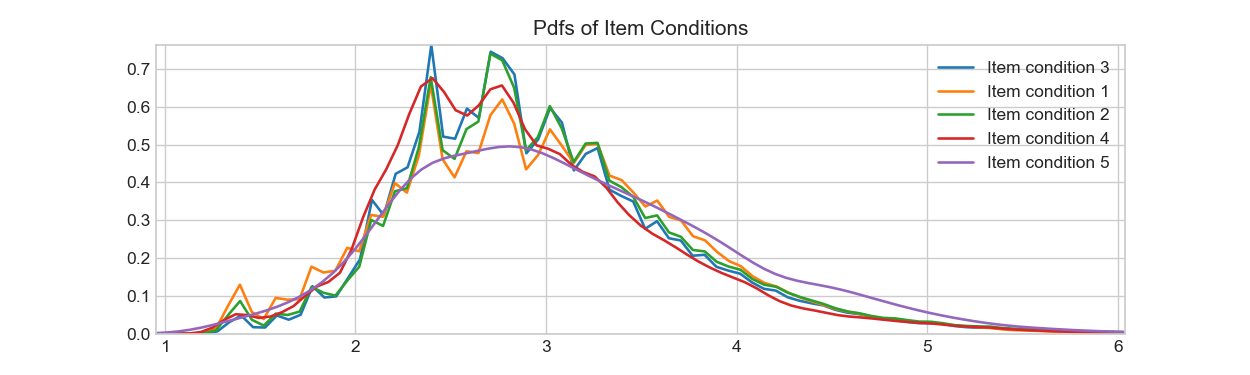

In [108]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Pdfs of Item Conditions")
sns.kdeplot(np.log(x[0]+1), ax=ax, label=f'Item condition {item_conditions[0]}')
sns.kdeplot(np.log(x[1]+1), ax=ax, label=f'Item condition {item_conditions[1]}')
sns.kdeplot(np.log(x[2]+1), ax=ax, label=f'Item condition {item_conditions[2]}')
sns.kdeplot(np.log(x[3]+1), ax=ax, label=f'Item condition {item_conditions[3]}')
sns.kdeplot(np.log(x[4]+1), ax=ax, label=f'Item condition {item_conditions[4]}')
plt.show()

### Not able to infer much from the log plot

<IPython.core.display.Javascript object>


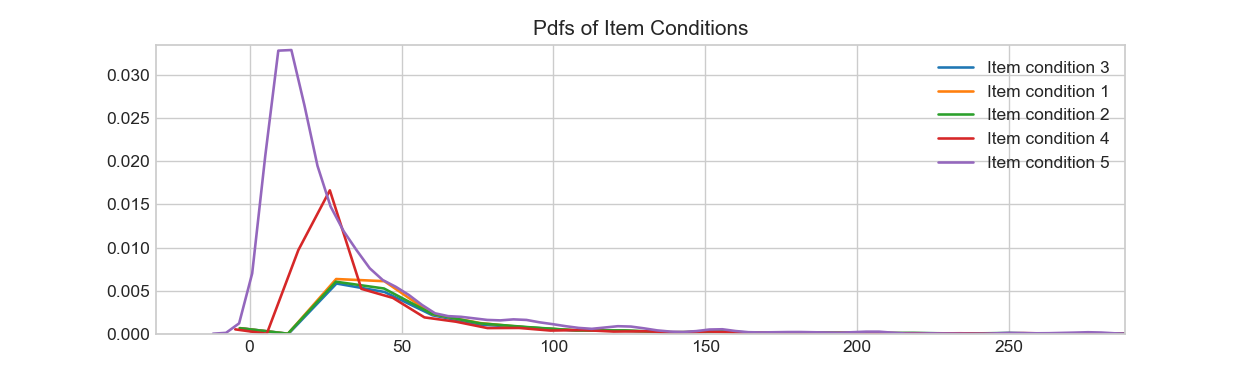

In [106]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Pdfs of Item Conditions")
sns.kdeplot(x[0], ax=ax, label=f'Item condition {item_conditions[0]}')
sns.kdeplot(x[1], ax=ax, label=f'Item condition {item_conditions[1]}')
sns.kdeplot(x[2], ax=ax, label=f'Item condition {item_conditions[2]}')
sns.kdeplot(x[3], ax=ax, label=f'Item condition {item_conditions[3]}')
sns.kdeplot(x[4], ax=ax, label=f'Item condition {item_conditions[4]}')
plt.show()

#### Inference from the above Pdfs
1. The likely hood of finding an item with __*condition 5*__ is more in the __*lower price range*__
1. The likely hood of finding an item with __*condition 4*__ is more in the __*slightly higher price range*__
1. The likely hood of finding itmes with __*conditions 3,2,1*__ is more in the __*higher price ranges*__
> However regardless of the item condition, an item can be found in any price range, it is just the probability of finding 
an <br> __item with a lower item condition number is more in the higher price range.__

### Brand Name

In [111]:
len(all_df.brand_name.unique())

4810

>There are 4810 Brands. *That's a lot of brands*

#### Top 25 Brands

In [4]:
all_df.brand_name.fillna(value='None', inplace=True)

In [5]:
all_df.brand_name.unique()

array(['None', 'Razer', 'Target', ..., 'Astroglide', 'Cumberland Bay',
       'Kids Only'], dtype=object)

In [12]:
all_df.brand_name.value_counts().sort_values(ascending=False)[0:25]

None                 631296
PINK                  54060
Nike                  54013
Victoria's Secret     48020
LuLaRoe               31017
Apple                 17297
FOREVER 21            15181
Nintendo              15003
Lululemon             14558
Michael Kors          13927
American Eagle        13251
Rae Dunn              12292
Sephora               12159
Coach                 10463
Disney                10351
Bath & Body Works     10346
Adidas                10199
Funko                  9235
Under Armour           8458
Sony                   7992
Old Navy               7566
Hollister              6944
Carter's               6383
Urban Decay            6206
The North Face         6171
Name: brand_name, dtype: int64

<IPython.core.display.Javascript object>


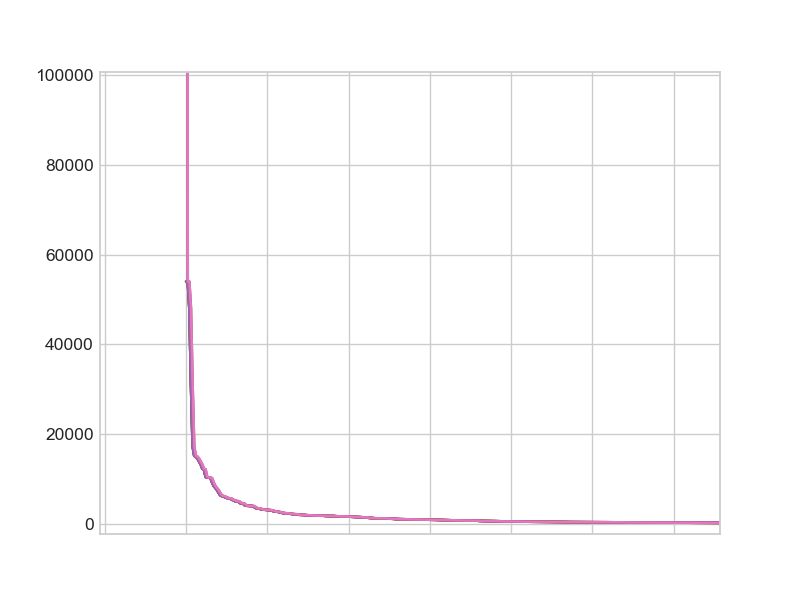

In [142]:
all_df.brand_name.value_counts().plot()
plt.show()

In [20]:
all_df.brand_name.describe()

count     1480845
unique       4810
top          None
freq       631296
Name: brand_name, dtype: object

In [30]:
brand_name_cum_sum_of_counts = all_df.brand_name.value_counts().cumsum()
brand_name_cum_sum_of_counts = brand_name_cum_sum_of_counts / len(all_df)
print(f'Percentage of Products without a brand name : {np.round(brand_name_cum_sum_of_counts[0],decimals=4) * 100}%')
print(f'80% of products by {len(brand_name_cum_sum_of_counts[brand_name_cum_sum_of_counts < 0.8])}% of brands')

Percentage of Products without a brand name : 42.63%
80% of products by 65% of brands


__Distribution is heavily skewed. *80% of products in the database are from 65% brands* __
<br> <br>
__Major contribution is made by products without a brand name__

<IPython.core.display.Javascript object>


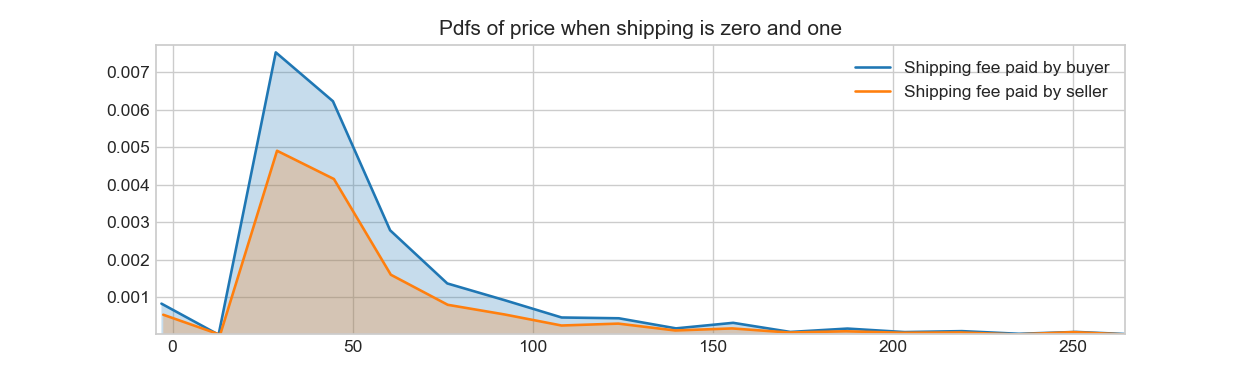

In [33]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Pdfs of price when shipping is zero and one")
sns.kdeplot(all_df[all_df['shipping'] == 0].price, ax=ax, label='Shipping fee paid by buyer', shade=True)
sns.kdeplot(all_df[all_df['shipping'] == 1].price, ax=ax, label='Shipping fee paid by seller', shade=True)
plt.show()

> Not able to infer much from the regular kde. <br>
$\therefore$ attempting $\log(1+price)$

<IPython.core.display.Javascript object>


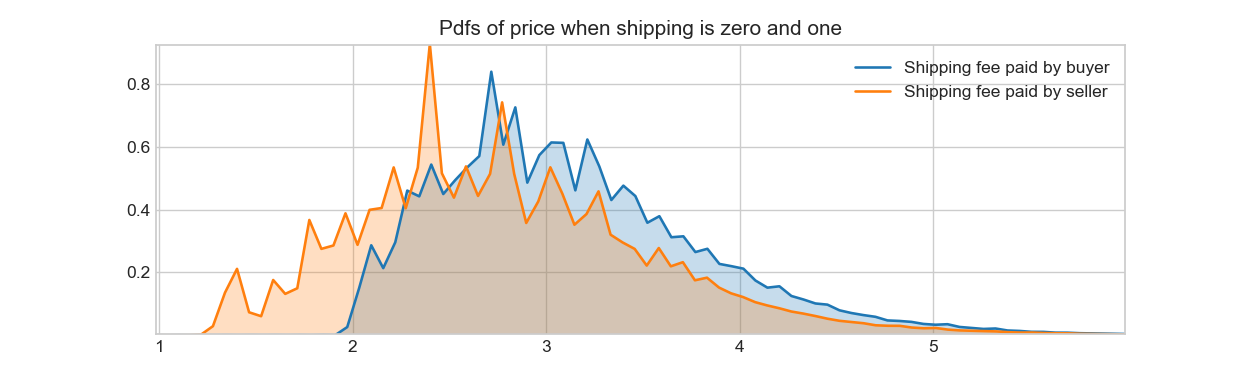

In [34]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Pdfs of price when shipping is zero and one")
sns.kdeplot(np.log(all_df[all_df['shipping'] == 0].price + 1), ax=ax, label='Shipping fee paid by buyer', shade=True)
sns.kdeplot(np.log(all_df[all_df['shipping'] == 1].price + 1), ax=ax, label='Shipping fee paid by seller', shade=True)
plt.show()

### What the MerCari!!! Prices are lower when seller bares the shipping
<img src="OhMyGod.gif" width="500" height="500" />

### Category

In [38]:
all_df.category_name.describe()

count                                            1474527
unique                                              1287
top       Women/Athletic Apparel/Pants, Tights, Leggings
freq                                               60163
Name: category_name, dtype: object

In [46]:
all_df.category_name.value_counts()[0:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60163
Women/Tops & Blouses/T-Shirts                     46360
Beauty/Makeup/Face                                34268
Beauty/Makeup/Lips                                29880
Electronics/Video Games & Consoles/Games          26544
Name: category_name, dtype: int64

__Category can be divided in to 3 sub categories, delimited by the forward slash__

In [59]:
sub_cat_df = all_df.category_name.str.split(pat='/', n=2, expand=True)
sub_cat_df.head()

,0,1,2
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


In [62]:
sub_cat_df.columns = ['general_cat','sub_cat_1','sub_cat_2']

In [63]:
sub_cat_df.head()

,general_cat,sub_cat_1,sub_cat_2
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


In [64]:
all_df['general_category'] = sub_cat_df.general_cat
all_df['sub_cat_1'] = sub_cat_df.sub_cat_1
all_df['sub_cat_2'] = sub_cat_df.sub_cat_2
all_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [65]:
all_df.drop(columns=['category_name'], inplace=True)
all_df.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,None,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [68]:
print(all_df.general_category.describe())
print('--------------------------------')
print(all_df.sub_cat_1.describe())
print('--------------------------------')
print(all_df.sub_cat_2.describe())

count     1474527
unique         10
top         Women
freq       664072
Name: general_category, dtype: object
--------------------------------
count              1474527
unique                 113
top       Athletic Apparel
freq                134331
Name: sub_cat_1, dtype: object
--------------------------------
count                     1474527
unique                        871
top       Pants, Tights, Leggings
freq                        60163
Name: sub_cat_2, dtype: object


> Number of women products is more. That's a no brainer

In [72]:
all_df.general_category.unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', nan,
       'Handmade'], dtype=object)

<IPython.core.display.Javascript object>


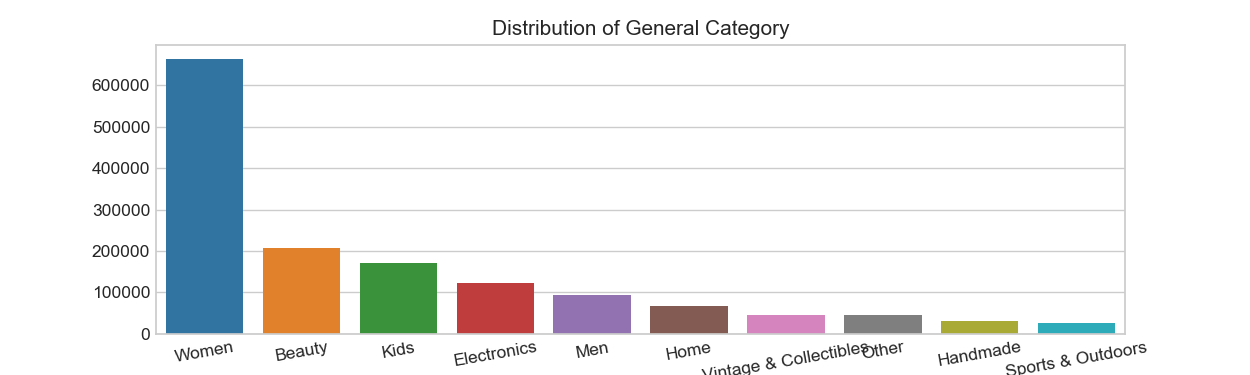

In [85]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Distribution of General Category")
x = all_df.general_category.value_counts().index.values.astype('str')
y = all_df.general_category.value_counts().values
p = sns.barplot(x=x, y=y)
p.set_xticklabels(rotation=10, labels=x)
plt.show()

<IPython.core.display.Javascript object>


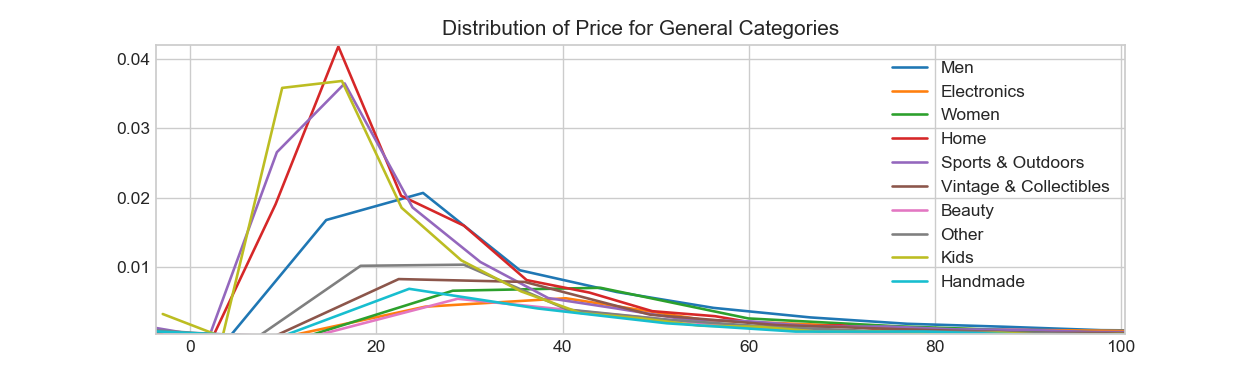

In [93]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.set_title("Distribution of Price for General Categories")
for gen_cat in all_df.general_category.unique():
    sns.kdeplot(all_df[all_df['general_category'] == gen_cat].price, label=gen_cat)
plt.show()

1. Probability of finding **Kids, Home and Sports & Outdoor** categories in the the **lower price range** is more.
1. Probability of finding **Men, Women, Electronics, Others etc** categories in the the **Higher price range** is more.

In [109]:
all_df.general_category.fillna(value='None', inplace=True)

<IPython.core.display.Javascript object>


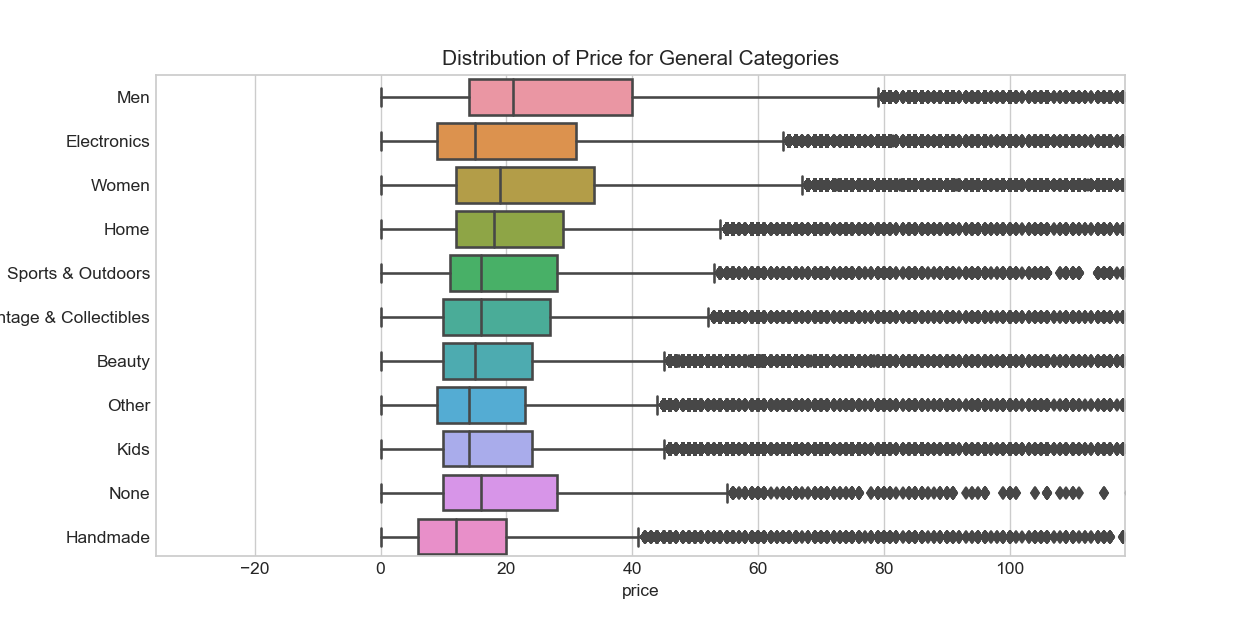

In [113]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Distribution of Price for General Categories")
p = sns.boxplot(y = 'general_category', x='price',\
           data = all_df)
plt.show()

### One more popular belief shattered!! Bravo MerCari
### Men have more products in the higher price range than Women

In [109]:
all_df.sub_cat_1.fillna(value='None', inplace=True)

In [117]:
all_df.sub_cat_1.describe()

count              1474527
unique                 113
top       Athletic Apparel
freq                134331
Name: sub_cat_1, dtype: object

In [118]:
all_df.sub_cat_1.value_counts()[0:5]

Athletic Apparel    134331
Makeup              124361
Tops & Blouses      106912
Shoes               100431
Jewelry              61702
Name: sub_cat_1, dtype: int64

In [119]:
all_df.sub_cat_2.fillna(value='None', inplace=True)

In [120]:
all_df.sub_cat_2.describe()

count                     1480845
unique                        872
top       Pants, Tights, Leggings
freq                        60163
Name: sub_cat_2, dtype: object

In [122]:
all_df.sub_cat_2.value_counts()[0:5]

Pants, Tights, Leggings    60163
Other                      50080
Face                       50073
T-Shirts                   46360
Shoes                      32160
Name: sub_cat_2, dtype: int64

### Title/Name

In [126]:
number_of_words  = all_df.name.apply(lambda x : len(x.split(' ')))

In [137]:
# Code copied from the description python note book

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [139]:
processed_titles=[]

for (index, title) in enumerate(all_df.name.values):
    processedTitleWords = []
    cleanedTitle = cleanpunc(cleanhtml(title))
    for word in cleanedTitle.split():
        word_in_lowercase = word.lower()
        if(word_in_lowercase.isalpha and \
           (word_in_lowercase not in stop) and \
           len(word_in_lowercase)>2):
            processedTitleWords.append(sno.stem(word_in_lowercase).encode('utf8'))
    processed_titles.append(b" ".join(processedTitleWords))
    
processed_titles[:5]

[b'mlb cincinnati red shirt size',
 b'razer blackwidow chroma keyboard',
 b'ava-viv blous',
 b'leather hors statu',
 b'24k gold plate rose']

In [140]:
all_df['name'] = processed_titles
all_df['name'] = all_df.name.str.decode('utf8')
all_df.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
0,0,mlb cincinnati red shirt size,3,None,10.0,1,No description yet,Men,Tops,T-shirts
1,1,razer blackwidow chroma keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,ava-viv blous,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,leather hors statu,1,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24k gold plate rose,1,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [141]:
import wordcloud

In [145]:
all_df.name.values.tolist()[0:3]

['mlb cincinnati red shirt size',
 'razer blackwidow chroma keyboard',
 'ava-viv blous']

In [162]:
wc= wordcloud.WordCloud(background_color='black', width=600)
wc.collocations = False
wc_image = wc.generate(" ".join(all_df.name.values.tolist()))

In [161]:
wc.generate.__doc__

'Generate wordcloud from text.\n\n        The input "text" is expected to be a natural text. If you pass a sorted\n        list of words, words will appear in your output twice. To remove this\n        duplication, set ``collocations=False``.\n\n        Alias to generate_from_text.\n\n        Calls process_text and generate_from_frequencies.\n\n        Returns\n        -------\n        self\n        '

<IPython.core.display.Javascript object>


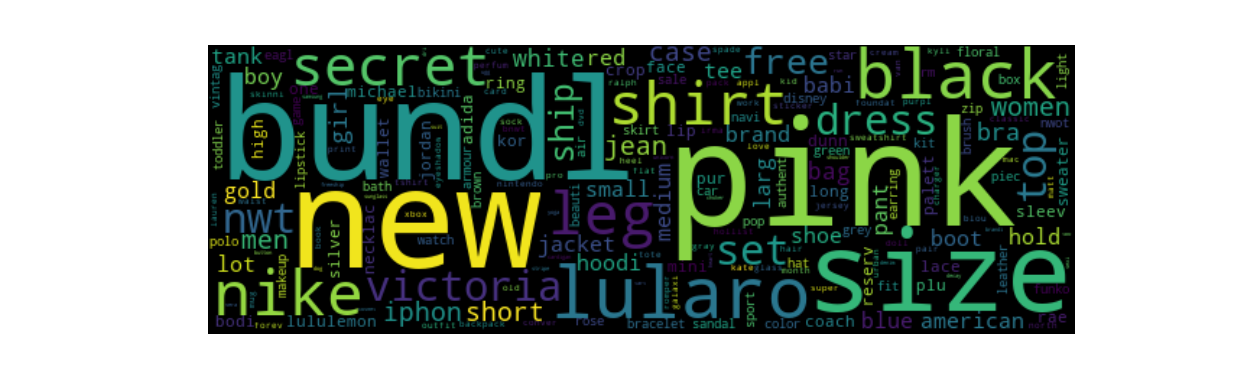

In [164]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
plt.imshow(wc_image, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

__Top 10 words__

In [172]:
for i,key in enumerate(wc.words_.keys()):
    if(i>10):
        break
    print(f'{key} - Normalized frequency {wc.words_[key]}')

pink - Normalized frequency 1.0
bundl - Normalized frequency 0.9209773198826644
new - Normalized frequency 0.9142042879969474
size - Normalized frequency 0.8785624001335527
lularo - Normalized frequency 0.7560277598912499
black - Normalized frequency 0.6715675753022823
nike - Normalized frequency 0.5601345066895614
shirt - Normalized frequency 0.5111850420929622
leg - Normalized frequency 0.5101833965323984
secret - Normalized frequency 0.4905559132861129
victoria - Normalized frequency 0.48981660346760153


### Number of names with less than 3 words

In [190]:
mask = number_of_words < 3

In [195]:
all_df[mask].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
2,2,ava-viv blous,1,Target,10.0,1,ador top hint lace key hole back pale pink als...,Women,Tops & Blouses,Blouse
10,10,smashbox primer,2,Smashbox,8.0,1,full size 1oz [rm] sephora,Beauty,Makeup,Face
16,16,glitter eyeshadow,1,Wet n Wild,6.0,1,glitter eyeshadows; one brass one bleach,Beauty,Makeup,Eyes
29,29,kendra bundl,3,Hollister,16.0,1,29w 33l social stretch hollist jean *** pleas ...,Women,Jeans,Boot Cut
38,38,xbox one,3,Xbox,226.0,0,500gb come power cord one control recharg pack...,Electronics,Video Games & Consoles,Consoles


In [196]:
all_df[mask].shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(193181, 10)

### Item Description

In [181]:
all_df[all_df.item_description.notnull() == False]

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
511535,511535,shoe michell,4,None,9.0,0,NaN,Kids,Girls 0-24 Mos,Shoes
861230,861230,lipgloss,4,None,49.0,0,NaN,Beauty,Makeup,Lips
1224924,1224924,disney minni head band,3,Disney,9.0,0,NaN,Women,Women's Accessories,Hair Accessories
1264242,1264242,bianca,3,None,10.0,1,NaN,Women,Women's Accessories,Scarves & Wraps


In [182]:
all_df = all_df[all_df.item_description.notnull() == True]

In [183]:
processed_descriptions=[]

for (index, description) in enumerate(all_df.item_description.values):
    processedDiscriptionWords = []
    cleaned_description = cleanpunc(cleanhtml(description))
    for word in cleaned_description.split():
        word_in_lowercase = word.lower()
        if(word_in_lowercase.isalpha and \
           (word_in_lowercase not in stop) and \
           len(word_in_lowercase)>2):
            processedDiscriptionWords.append(sno.stem(word_in_lowercase).encode('utf8'))
    processed_descriptions.append(b" ".join(processedDiscriptionWords))
    
processed_descriptions[:5]

[b'descript yet',
 b'keyboard great condit work like came box port test work perfect light customiz via razer synaps app',
 b'ador top hint lace key hole back pale pink also avail white',
 b'new tag leather hors retail [rm] stand foot high sold pair question pleas ask free ship got storag',
 b'complet certif authent']

In [184]:
all_df['item_description'] = processed_descriptions
all_df['item_description'] = all_df.item_description.str.decode('utf8')
all_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
0,0,mlb cincinnati red shirt size,3,None,10.0,1,descript yet,Men,Tops,T-shirts
1,1,razer blackwidow chroma keyboard,3,Razer,52.0,0,keyboard great condit work like came box port ...,Electronics,Computers & Tablets,Components & Parts
2,2,ava-viv blous,1,Target,10.0,1,ador top hint lace key hole back pale pink als...,Women,Tops & Blouses,Blouse
3,3,leather hors statu,1,None,35.0,1,new tag leather hors retail [rm] stand foot hi...,Home,Home Décor,Home Décor Accents
4,4,24k gold plate rose,1,None,44.0,0,complet certif authent,Women,Jewelry,Necklaces


In [185]:
wc= wordcloud.WordCloud(background_color='black', width=600)
wc.collocations = False
wc_image = wc.generate(" ".join(all_df.item_description.values.tolist()))

<IPython.core.display.Javascript object>


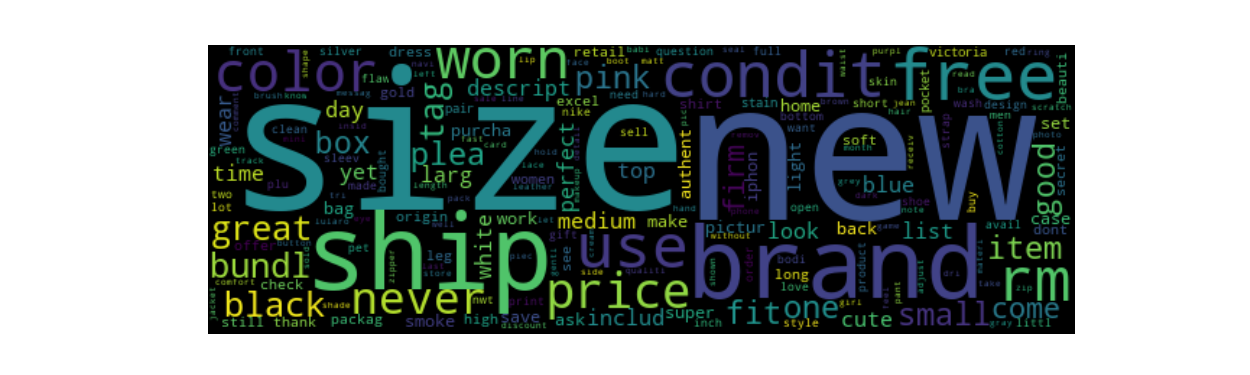

In [186]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
plt.imshow(wc_image, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [187]:
#Top 10 words
for i,key in enumerate(wc.words_.keys()):
    if(i>10):
        break
    print(f'{key} - Normalized frequency {wc.words_[key]}')

new - Normalized frequency 1.0
size - Normalized frequency 0.9690582600156322
ship - Normalized frequency 0.6432170270757761
brand - Normalized frequency 0.5629136020201615
free - Normalized frequency 0.5225524580636111
condit - Normalized frequency 0.5044511694089825
use - Normalized frequency 0.4726757119666513
rm - Normalized frequency 0.4494157965408742
worn - Normalized frequency 0.3751488065414754
color - Normalized frequency 0.3541715934825741
price - Normalized frequency 0.3525021544381426


In [189]:
all_df[all_df.item_description == 'descript yet'].shape

(82174, 10)

__There are ~82K products without description__

## Featurizing each column

In [197]:
all_df.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'general_category', 'sub_cat_1',
       'sub_cat_2'],
      dtype='object')

1. __There are no numerical variables at all, the only numerical variable is the price variable which is to be predicted__ 
1. __This scenario seems to be a perfect for Gradient Boosting Decision Trees__ 
1. __We still need to featurize the $name$ and $item\_description$ using either BOW or TFIDF__
1. __We shall use Microsoft's LightGBM because__
    1. __Microsoft makes everything easy take C# and VS Code for example__
    1. __LightGBM provides us the option to name individual features are categorical features, In xgBoost we have to one hot encode eevry feature. Which is laborious as well as drastically affects train and test times__
    
> Even LightGBM requires that each feature is in numericals and not strings. $\therefore$ We will employ LabelEncoders to convert features like brand name, general category etc 

### Apply $\log(price+1)$ on the data frame to calculate the Root Mean Squared Logarithmic Error.
${err=\sqrt{\frac{1}{n}\sum_{i=1}^{n}log(predict\_price_i+1)^2−log(actual\_price_i+1)^2}}$ <br>
> By applying $\log(price+1)$ on whole price column, we will predict $\log(price+1)$ and evaluate RMSE

In [258]:
all_df.price = np.log(all_df.price + 1)

In [5]:
all_df.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_category,sub_cat_1,sub_cat_2
0,0,mlb cincinnati red shirt size,3,None,2.397895,1,descript yet,Men,Tops,T-shirts
1,1,razer blackwidow chroma keyboard,3,Razer,3.970292,0,keyboard great condit work like came box port ...,Electronics,Computers & Tablets,Components & Parts
2,2,ava-viv blous,1,Target,2.397895,1,ador top hint lace key hole back pale pink als...,Women,Tops & Blouses,Blouse
3,3,leather hors statu,1,None,3.583519,1,new tag leather hors retail [rm] stand foot hi...,Home,Home Décor,Home Décor Accents
4,4,24k gold plate rose,1,None,3.806662,0,complet certif authent,Women,Jewelry,Necklaces


In [7]:
all_df.brand_name = all_df.brand_name.astype('str')
all_df.name = all_df.name.astype('str')
all_df.general_category = all_df.general_category.astype('str')
all_df.sub_cat_1 = all_df.sub_cat_1.astype('str')
all_df.sub_cat_2 = all_df.sub_cat_2.astype('str')

In [11]:
def remove_rm(description):
    if "[rm]" in description:
        return description.replace("[rm] ","")
    return description

In [13]:
all_df.item_description = all_df.item_description.apply(remove_rm)

In [218]:
all_df.columns

Index(['train_id', 'name', 'item_condition_id', 'brand_name', 'price',
       'shipping', 'item_description', 'general_category', 'sub_cat_1',
       'sub_cat_2'],
      dtype='object')

In [220]:
all_df.name = all_df.name.apply(remove_rm)

In [221]:
all_df.item_description = all_df.item_description.apply(remove_rm)

In [210]:
import re

In [406]:
all_df.name = all_df.name.apply(lambda x : re.sub('[\W_]+', ' ', x, flags=re.UNICODE))

In [407]:
all_df.item_description = all_df.item_description.apply(lambda x : re.sub('[\W_]+', ' ', x, flags=re.UNICODE))

In [471]:
all_df.to_pickle('all_df.p')